# Visualize Local Sea Level Change

This notebook visualizes local sea level data from [tide-monitoring stations](https://tidesandcurrents.noaa.gov/stations.html) in NOAA's Center for Operational Oceanographic Products and Service (CO-OPS) network for each month over years  up to 2023. More information is available at the [CO-OPS Relative Sea Level Trends Tool](https://www.climate.gov/news-features/features/interactive-map-how-has-local-sea-level-united-states-changed-over-time).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt

This code will generate graphs that show local sea level change (relative to the mean sea level from 1983–2001) for a given NOAA station.

According to [NOAA documentation](https://tidesandcurrents.noaa.gov/datum_options.html), Mean Sea Level (MSL) captures the arithmetic mean of hourly heights (in feet) observed over the [National Tidal Datum Epoch](https://tidesandcurrents.noaa.gov/datum-updates/ntde/). For reference, an MSL of 0 is the local mean sea level from 1983 to 2001.

In [2]:
def clean_data(df, years, months):
    """
    Replace any missing data using linear interpolation

    Inputs:
        df: DataFrame of NOAA data
        years: list of unique years for data (may be different depending on the station)
        months: list of integers from 1 to 12 for each month
    """

    # Get list of years and months where there are missing data
    missing_data = []
    for year_check in years:
        month_check = list(df.loc[df['Year'] == year_check, "Month"])
        # Check which month(s) are missing
        if len(month_check) != 12:
            missing_months = list(set(months) - set(month_check))
            for missing_month in missing_months:
                missing_data.append([year_check, missing_month])

    print("Missing data (replaced using linear interpolation):", missing_data)

    # Add empty rows for missing data
    df = df.set_index(['Year', 'Month'])
    for missing_year, missing_month in missing_data:
        df.loc[(missing_year, missing_month),:] = pd.Series()

    # Sort by month and year, then interpolate to replace empty rows with estimated values
    df = df.sort_index(ascending=True) \
        .interpolate(method='linear')
    
    return df

def map_msl(station, location, subfolder='graphs', year='all', grid=False, save=False):
    """
    Map the sea level over time, with one line per year
    
    Inputs:
        station: number for NOAA tide-monitoring station (like 8723214); view list of stations at https://tidesandcurrents.noaa.gov/stations.html
        location: name of the station's location (like Virginia Key, FL)
        subfolder: subfolder to save graphs to (if save=True); default is 'graphs'
        year: can be 'all' or a specific year (like 2023); default is 'all'
        grid: True to include axes, title, and colormap; False to only show lines; default is False
        save: True to export graph as a PNG; False to only display graph in notebook; default is False
    """

    # Read data directly from URL, based on station number
    df = pd.read_csv(f"https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=monthly_mean&application=NOS.COOPS.TAC.WL&begin_date=19000101&end_date=20231231&datum=MSL&station={station}&time_zone=GMT&units=english&format=csv", skipinitialspace = True)
    df = df.sort_values(by=['Year', 'Month'])
    
    years = df['Year'].unique()
    months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    # Initialize plot
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_xlim(1, 12)
    ax.set_ylim(df['MSL'].min(), df['MSL'].max())
    color_palette="YlGnBu"

    # Clean data by replacing any missing values
    df = clean_data(df, years, months)

    # Show all years
    if year == 'all':
        print(f"Data for Station {station} at {location} ({df.index.get_level_values('Year').min()} to {df.index.get_level_values('Year').max()})")

        # Create one line for each year showing sea level by month
        msl_lines = LineCollection([np.column_stack([months, df.loc[df.index.get_level_values('Year') == year, "MSL"]]) for year in years],
                                linestyles='solid',
                                cmap=color_palette)
        
        msl_lines.set_array(years)
        ax.add_collection(msl_lines)
        fig.colorbar(msl_lines)

        if grid:
            # Set title and x-axis and y-axis labels
            plt.title(f"Sea Level Change for {location}", loc='left', fontsize=20)
            plt.title(f"{df.index.get_level_values('Year').min()}-{df.index.get_level_values('Year').max()}", loc='right', fontsize=20)
            plt.xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) 
            plt.ylabel("Elevation (feet)\nRelative to Mean Sea Level Datum")
            filename = f'{subfolder}/mean_sea_level_{station}_grid.png'
        else:
            fig.patch.set_visible(False)
            ax.axis('off')
            filename = f'{subfolder}/mean_sea_level_{station}_nogrid.png'

        if save:
            plt.savefig(filename, dpi=300, format='png')
    
    # Show only one year
    elif year in range(df.index.get_level_values('Year').min(), df.index.get_level_values('Year').max() + 1):
        print(f"Data for Station {station} at {location} ({year})")
        plt.plot(months, df.loc[df.index.get_level_values('Year') == year, "MSL"])

        if grid:
            # Set title and x-axis and y-axis labels
            plt.title(f"Sea Level Change for {location}", loc='left', fontsize=20)
            plt.title(f"Monthly in {year}", loc='right', fontsize=20)
            plt.xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            plt.ylabel("Elevation (feet)\nRelative to Mean Sea Level Datum")
            filename = f'{subfolder}/mean_sea_level_{station}_{year}_grid.png'
        else:
            fig.patch.set_visible(False)
            ax.axis('off')
            filename = f'{subfolder}/mean_sea_level_{station}_{year}_nogrid.png'

        if save:
            plt.savefig(filename, dpi=300, format='png')
    
    plt.show()

# Exploring Data from Virginia Key, FL

Missing data (replaced using linear interpolation): [[2016, 2]]
Data for Station 8723214 at Virginia Key, FL (1994 to 2023)


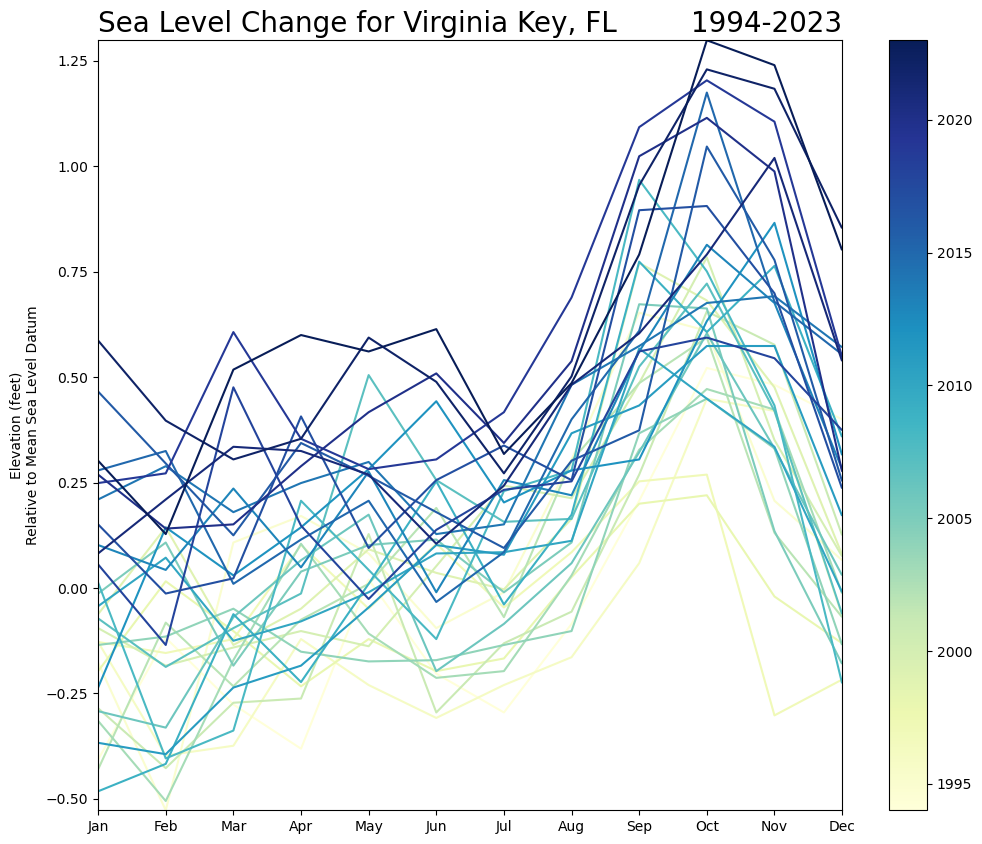

In [3]:
# Virginia Key, FL, (8723214)
map_msl('8723214', "Virginia Key, FL", subfolder='final/documentation', grid=True, save=True)

Missing data (replaced using linear interpolation): [[2016, 2]]
Data for Station 8723214 at Virginia Key, FL (2023)


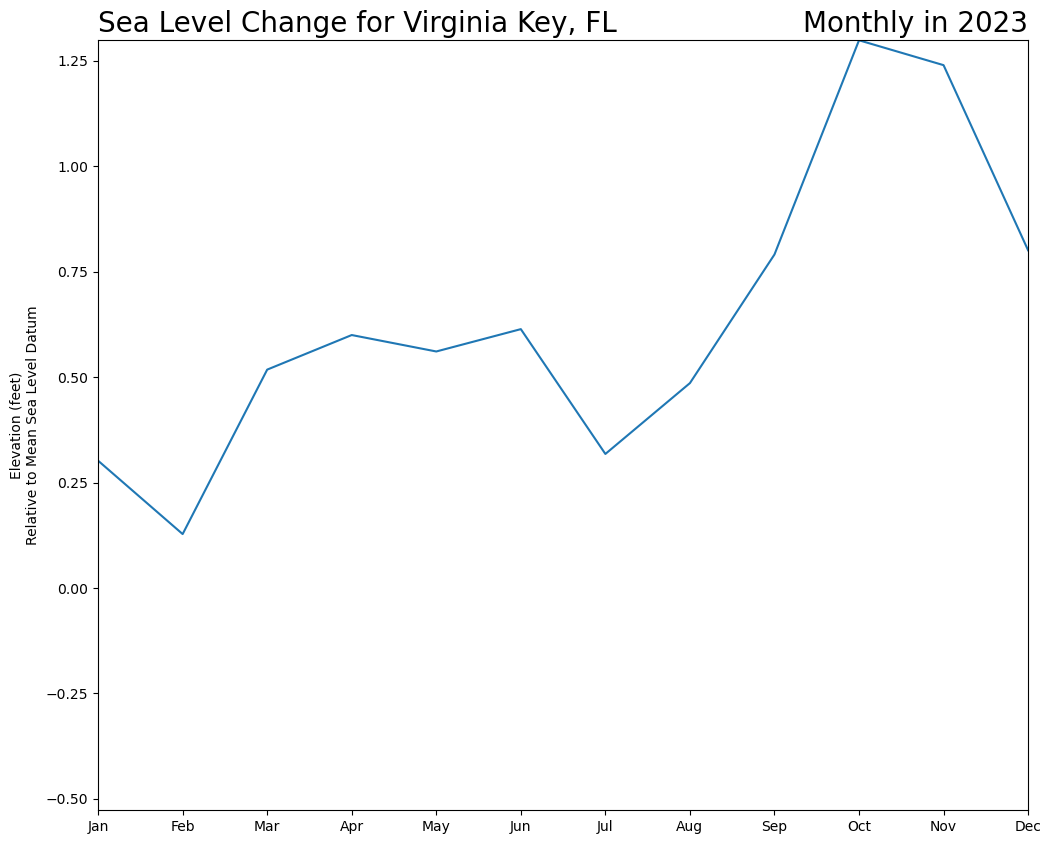

In [4]:
# Virginia Key, FL, (8723214)
map_msl('8723214', "Virginia Key, FL", year=2023, grid=True, save=False)

Missing data (replaced using linear interpolation): [[2016, 2]]
Data for Station 8723214 at Virginia Key, FL (1994 to 2023)


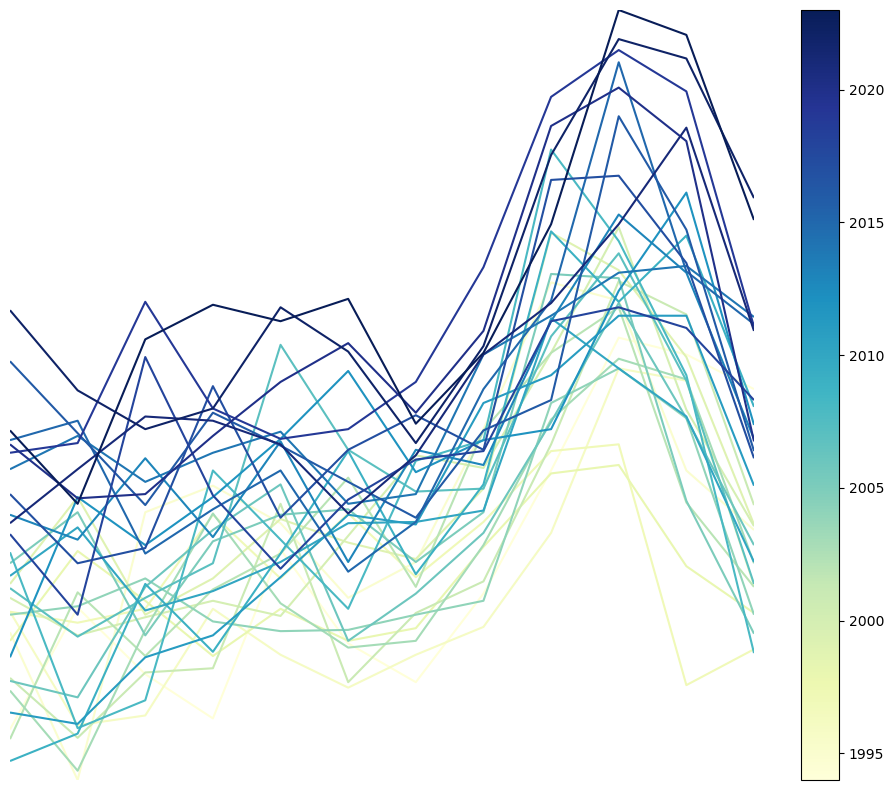

In [5]:
# Virginia Key, FL, (8723214)
# Graph used for climate storytelling artwork
map_msl('8723214', "Virginia Key, FL", grid=False, save=True)

# Exploring Data from Other Regions

Missing data (replaced using linear interpolation): [[2009, 9], [2009, 10], [2012, 4]]
Data for Station 8761724 at Grand Isle, LA (1978 to 2023)


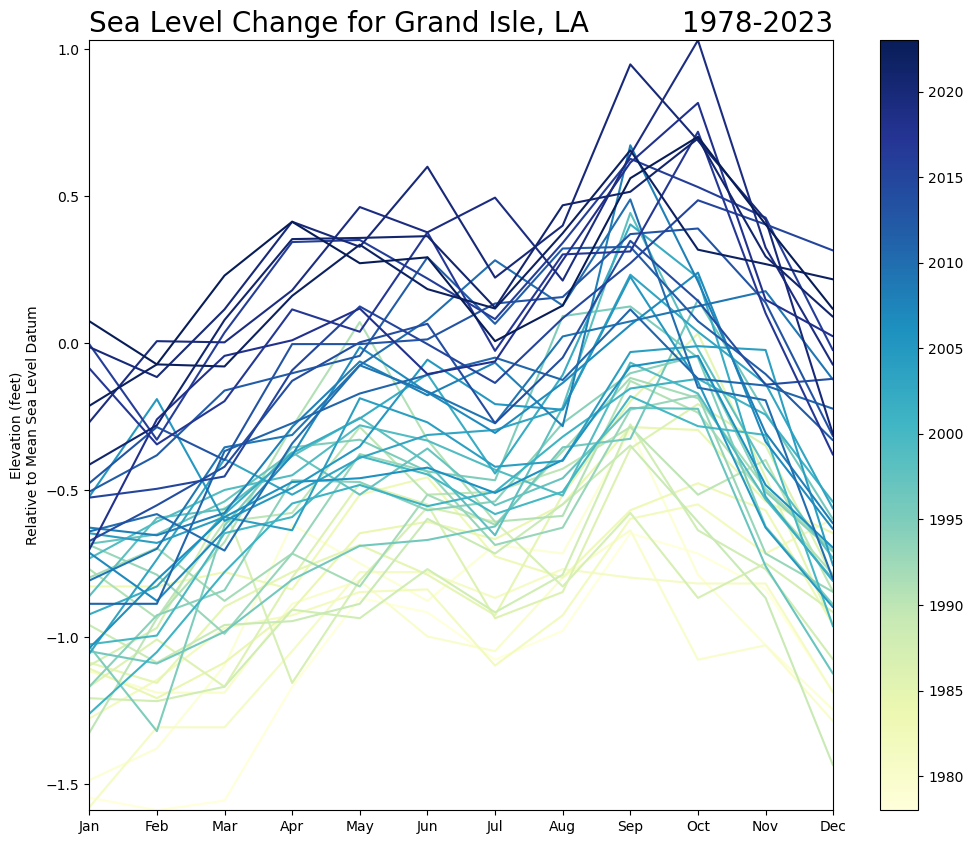

In [6]:
# Grand Isle, LA, (8761724)
map_msl('8761724', "Grand Isle, LA", grid=True, save=False)

Missing data (replaced using linear interpolation): [[1993, 1], [1993, 2], [1993, 3], [1993, 4], [1993, 5], [1993, 6], [1993, 7], [1993, 9], [2009, 12], [2010, 1], [2014, 12], [2019, 8], [2019, 7]]
Data for Station 8771013 at Eagle Point, TX (1993 to 2023)


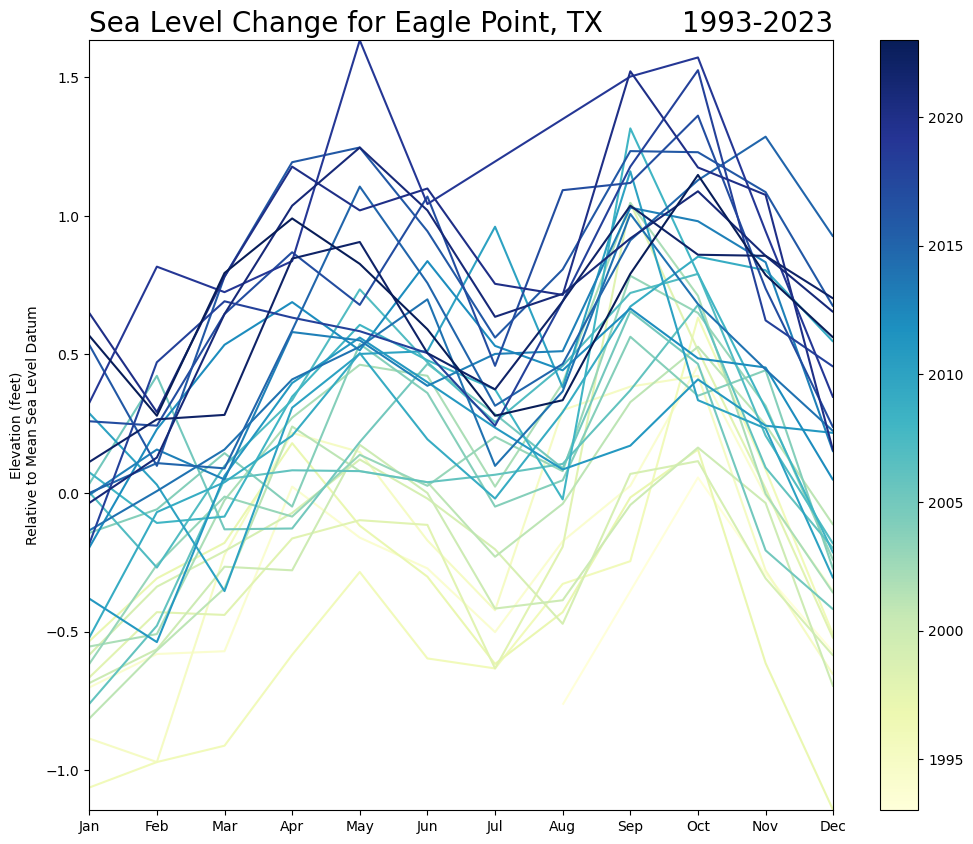

In [7]:
# Eagle Point, TX, (8771013)
map_msl('8771013', "Eagle Point, TX", grid=True, save=False)